In [2]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm as tq
from IPython import display

## Stochastic Reaction-Diffusion Simulation
We want to simulate particles diffusing on a 10x10 uM frame, with a mean density of 0.05 particles/um^2<br>
Particles diffuse according to brownian motion, steps are sampled from a 2D gaussian with mean 0, and sdev = sqrt(2 D t_on)<br>


Parameters: <br>

$ D $ is diffusion coefficient (um/s) <br>


$ \langle t_{\text{off}} \rangle $ is expected time bound $\rightarrow$ $ \frac{1}{\langle t_{\text{off}} \rangle} $ = $ k_{\text{off}} $ (dissociation rate)


$ \langle t_{\text{on}} \rangle $ is expected time unbound $\rightarrow$ $ \frac{1}{\langle t_{\text{on}} \rangle} $ = $ k_{\text{on}} $ (association rate)<br>


*!Reminder:* <br>
$ PDF, f(\lambda) = \lambda e^{-\lambda x} $<br>
$ CDF,  F(\lambda) = 1-e^{-\lambda x} $

### Distributions of dwell and idle times

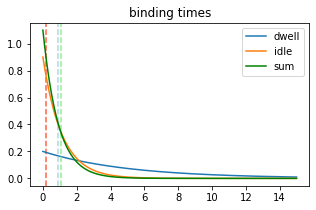

In [3]:
def exp(x, lamb=0.5):
    return lamb*np.exp(-lamb*x)


# setup plot
plt.figure(figsize=[5,3])
times = np.linspace(0, 15, 1000)

# for dwell times:
k_off = 0.2
d_dwell = [exp(i, k_off) for i in times]
plt.axvline(k_off, linestyle='--', color='tomato')
plt.plot(times, d_dwell, label='dwell')

# for idle times:
k_on = 0.9
d_idle = [exp(i, k_on) for i in times]
plt.axvline(k_on, linestyle='--', color='lightblue')
plt.plot(times, d_idle, label='idle')

# sum of both:
k_sum = k_off + k_on
d_sum = [exp(i, k_sum) for i in times]
plt.axvline(k_sum, linestyle='--', color='lightgreen')
plt.plot(times, d_sum, label='sum', color='green')


# plot settings
plt.title('binding times')
plt.legend()
plt.show()

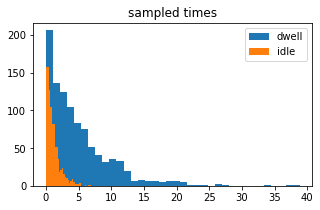

In [7]:
# let's check by sampling from distrubtion
sample_dwell = np.random.exponential(1/k_off, 1000)
sample_idle = np.random.exponential(1/k_on, 1000)
plt.figure(figsize=[5,3])
plt.hist(sample_dwell, bins='fd', label='dwell')
plt.hist(sample_idle, bins='fd', label='idle')
plt.title('sampled times')
plt.legend()
plt.show()

### Simple SSA degradation
$A \xrightarrow[k]{} \emptyset$

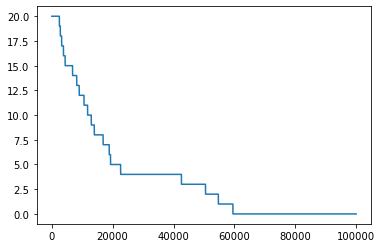

In [8]:
# initialize system
n_0 = 20
k = 0.1
dt = 0.0005
tmax = 100000
n_t = [n_0]

# simulate
for t in range(1, tmax):
    r = np.random.uniform()
    a_t = n_t[t-1]
    if r < (a_t * k * dt):
        n_t.append(a_t - 1)
    else:
        n_t.append(a_t)

# plot results
plt.figure()
plt.plot(n_t)
plt.show()

## 2. Gillespie SSA
From Radek Erban et al.

Property of uniformly distributed variable $r \in [0,1]$:<br>
$r_{ab}$ is when $r$ in subinterval $(a,b) \subset (0,1)$, $a < b.$<br>
$p(r_{ab}) = b-a$<br>

$A + A \xleftarrow[k_2]{} \xrightarrow{k_1} AA $<br><br>

1. Generate $r_1, r_2$ which are uniformly distributed in (0, 1)<br><br>
2. p(reaction occurs) = $\alpha_i$:<br>
$\alpha_1 = A(t)(A(t) - 1)k_1$,<br>
$\alpha_2 = AA(t)k_2$,<br>
$\alpha_0 = \alpha_1 + \alpha_2$<br><br>
3. Compute time $\tau$ in which next reaction takes place:<br>
$\tau = \frac{1}{\alpha_0}ln[\frac{1}{r_1}]$<br><br>
4. Probability that ith reaction occurs given by $\alpha_i/\alpha_0 $:
<br>
$ A(t+\tau) = \left\{  \begin{array}{ll} A(t) - 2 & \text{if  }r_2 < \alpha_1/ \alpha_0 \\  A(t) + 2 & \text{if  }r_2 \geq \alpha_1/\alpha_0   \end{array}   \right. $
<br><br>
*here number of dimers $AA$ is simply $A(t=0) - A(t)$ *<br><br>

In [9]:
# initialize params
n0 = 100
k1 = 0.0001
k2 = 0.005
maxstep = 10000
At = [n0]
tlist = [0]

def tauTime(a0):
    '''returns tau given r1 in (0,1)'''
    # tau = (1/a0)*np.log(1/r1)
    tau = np.random.exponential(1/a0)
    return tau

def sim(n0, k1, k2, maxstep):
    At = [n0]
    tlist = [0]

    for step in range(1, maxstep):
        '''simulate'''
        # particle numbers
        a_t = At[step-1]
        aa_t = n0 - a_t

        # sample r
        r2 = np.random.uniform()

        # calculate alphas and get tau
        a1 = a_t * (a_t - 1) * k1
        a2 = aa_t * k2
        a0 = a1 + a2
        tau = tauTime(a0)

        # add t+tau to list
        t = tlist[step-1]
        tlist.append(t+tau)

        # choose reaction
        if r2 < (a1/a0):
            At.append(a_t - 2)
        else:
            At.append(a_t + 2)
        
    return At, tlist

particles, times = sim(n0, 0.1, 1, 200)

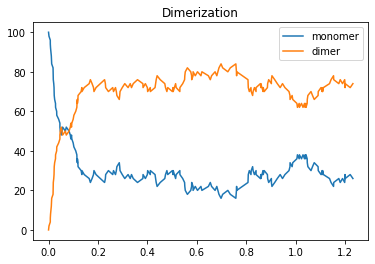

In [10]:
# plot results
plt.figure()
plt.plot(times, particles, label='monomer')
plt.plot(times, [n0-i for i in particles], label='dimer')
plt.title('Dimerization')
plt.legend()
plt.show()

## 3. FKBP homodimerization in presence of AP20187
*rate units $k_i$ are in $s^{-1}$

$F + A \xleftarrow[k_2]{} \xrightarrow{k_1} FA $<br><br>
$FA + F \xleftarrow[k_4]{} \xrightarrow{k_3} FAF$<br><br>

1. Generate $r_1, r_2$ which are uniformly distributed in (0, 1)<br><br>
2. p(reaction occurs) = $\alpha_i$:<br>
$\alpha_1 = F(t)A(t)k_1$,<br>
$\alpha_2 = FA(t)k_2$,<br>
$\alpha_3 = FA(t)F(t)k_3$<br>
$\alpha_4 = FAF(t)k_4$,<br>
$\alpha_5 = FAF(t)k_5$,<br>
$\alpha_0 = \alpha_1 + \alpha_2$<br><br>
3. Compute time $\tau$ in which next reaction takes place:<br>
$\tau = \frac{1}{\alpha_0}ln[\frac{1}{r_1}]$<br>
OR simply sample from an exponential distribution with scaling factor $1/\alpha_0$<br><br>
4. Probability that ith reaction occurs given by $\alpha_i/\alpha_0:$<br><br>

$F(t+\tau) = \left\{     \begin{array}{ll}        F(t) - 1 & \text{if  }r_2 < (\alpha_1+\alpha_3)/\alpha_0 \\
        F(t) + 1 & \text{if  }r_2 \geq (\alpha_1+\alpha_3)/\alpha_0    \end{array} \right. $
<br><br><br>
$ FA(t+\tau) = \left\{    \begin{array}{ll}        FA(t) + 1 & \text{if  }r_2 < (\alpha_1+\alpha_4)/\alpha_0 \\
        FA(t) - 1 & \text{if  }r_2 \geq (\alpha_1+\alpha_4)/\alpha_0    \end{array}\right. $
<br><br><br>
$ FAF(t+\tau) = \left\{    \begin{array}{ll}        FAF(t) + 1 & \text{if  }r_2 < \alpha_3/\alpha_0 \\
        FAF(t) - 1 & \text{if  }\alpha_3/\alpha_0 \leq r_2 < (\alpha_3+\alpha_4)/\alpha_0 \\
        FAF(t) & \text{if  }r_2 \geq (\alpha_3+\alpha_4)/\alpha_0    \end{array}\right. $
<br><br><br>
$ A(t+\tau) = \left\{    \begin{array}{ll}        A(t) - 1 & \text{if  }r_2 < \alpha_1/\alpha_0 \\
        A(t) + 1 & \text{if  }\alpha_1/\alpha_0 \leq r2 < (\alpha_1+\alpha_2)/\alpha_0 \\
        A(t) & \text{if  }r2 \geq (\alpha_1+\alpha_2)/\alpha_0    \end{array} \right. $
<br><br><br>

In [11]:
def tauTime(avec):
    '''returns tau given r1 in (0,1)'''
    r1 = np.random.uniform()
    a0 = sum(avec)
    tau = (1/a0)*np.log(1/r1)

    return tau


def get_alphas(pvec, kvec):
    '''Returns probability of reaction events: alpha_i
    pvec : [a_t, f_t, fa_t, faf_t]
    kvec : [k1, k2, k3, k4]
    '''
    a_t, f_t, fa_t, faf_t = pvec
    k1, k2, k3, k4, k5 = kvec

    # propensity functions
    a1 = f_t * a_t * k1
    a2 = fa_t * k2
    a3 = fa_t * f_t * k3
    a4 = faf_t * k4
    a5 = faf_t * k5

    return [a1, a2, a3, a4, a5]


def chooseR(pvec, avec):
    r2 = np.random.uniform()
    a_t, f_t, fa_t, faf_t = pvec
    a1, a2, a3, a4, a5 = avec
    a0 = sum(avec)

    # a1 conditions
    if r2 < a1/a0:
        a_t -= 1
        f_t -= 1
        fa_t += 1
    
    # a2 conditions
    if a1/a0 <= r2 < (a1+a2)/a0:
        a_t += 1
        f_t += 1
        fa_t -= 1
    
    # a3 conditions:
    if (a1+a2)/a0 <= r2 < (a1+a2+a3)/a0:
        f_t -= 1
        fa_t -= 1
        faf_t += 1
    
    # a4 conditions:
    if (a1+a2+a3)/a0 <= r2 < (a1+a2+a3+a4)/a0:
        f_t += 1
        fa_t += 1
        faf_t -= 1
    
    if (a1+a2+a3+a4)/a0 <= r2 < a0:
        f_t += 2
        a_t += 1
        faf_t -= 1
    
    return [a_t, f_t, fa_t, faf_t]


def sim(pvec_initial, kvec, maxstep):
    '''Returns list of lists for particle number evolution: [At, Ft, FAt, FAFt]'''
    plist = [pvec_initial]
    tlist = [0]

    for step in range(1, maxstep):
        '''simulate'''
        # vector of particle numbers at step: [a_t, f_t, fa_t, faf_t]
        pvec = plist[step-1]

        # get vector of reaction probabilities avec
        avec = get_alphas(pvec=pvec, kvec=kvec)

        # add tau time to list
        tau = tauTime(avec)
        t = tlist[step-1]
        tlist.append(t+tau)

        # choose reaction and update pvec
        pvec_update = chooseR(pvec, avec)
        plist.append(pvec_update)
        
    return plist, tlist

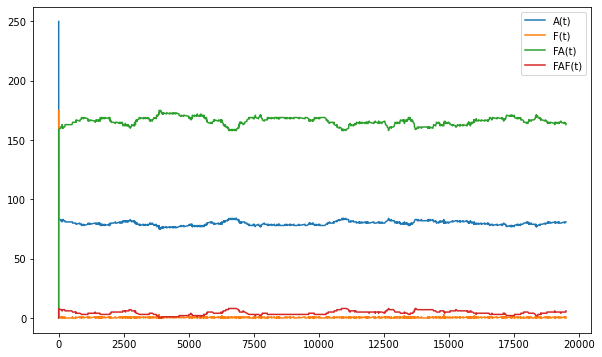

In [13]:
particles, times = sim(pvec_initial=[250,175,0,0], kvec=[.02,.0001,.002,.001,.001], maxstep=1000)

plt.figure(figsize=[10,6])
plt.plot(times, [i[0] for i in particles], label='A(t)')
plt.plot(times, [i[1] for i in particles], label='F(t)')
plt.plot(times, [i[2] for i in particles], label='FA(t)')
plt.plot(times, [i[3] for i in particles], label='FAF(t)')
plt.legend()
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

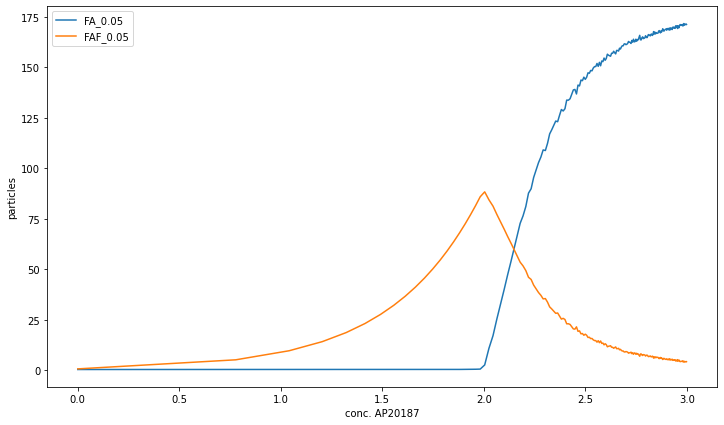

In [14]:
plt.figure(figsize=[12,7])

for k in tq(np.linspace(.05, 1, 1)):
    # initialize
    steady_faf = []
    steady_fa = []
    fmax = 200
    amax = 1000

    for x in range(1, amax, 5):
        particles, times = sim([x,fmax,0,0], kvec=[.05, .0001, k, .001, .001], maxstep=10000)
        faf = [i[3] for i in particles][1000:]
        fa = [i[2] for i in particles][1000:]
        ss_faf = np.divide(sum(faf), 10000)
        ss_fa = np.divide(sum(fa), 10000)
        steady_faf.append(ss_faf)
        steady_fa.append(ss_fa)

    plt.plot(np.log10(range(1, amax, 5)), steady_fa, label=f'FA_{k:.2f}')
    plt.plot(np.log10(range(1, amax, 5)), steady_faf, label=f'FAF_{k:.2f}')

# config plot
plt.xlabel('conc. AP20187')
plt.ylabel('particles')
plt.legend()
plt.show()

## Diffusion
$A_{i,j} \xleftarrow[d]{}\xrightarrow{d} ... \xleftarrow[d]{} \xrightarrow{d} A_{m,n}   $<br><br>


In [15]:
class SSAmodel():
    '''compartment based reaction-diffusion model'''
    def __init__(self, surface, propensities, reactions):
        for key,val in surface.items():
            setattr(self, key, val)
        self.rprops = propensities
        self.reacts = reactions
        self.delta = self.D / (self.length/self.bins)**2
        self.time = 0

        # setup matrix; if particles/compartments < 1 then all compartments have one particle
        if self.N0 // self.bins**2 == 0:
            self.matrix = np.full((self.bins, self.bins), 1)
            self.matrix[20:30, 20:30] = 10
        else:
            self.matrix = np.full((self.bins, self.bins), self.N0 // self.bins**2)
            self.matrix[20:30, 20:30] = 10

    def simulate(self, maxstep):
        '''simulates system for specified steps'''
        for _ in tqdm(range(maxstep)):
            # random uniform variable
            r = np.random.uniform()

            # calculate diffusion propensity matrix, each cell is propensity for compartment i,j
            self.propmatrix = self.matrix * self.delta
            self.propmatrix= np.divide(self.propmatrix, np.sum(self.propmatrix))

            # choose diffusion direction from propensities: up, down, left, right
            directions = {
                'up': np.sum(self.propmatrix[1:,:]),
                'down': np.sum(self.propmatrix[:-1,:]),
                'left': np.sum(self.propmatrix[:,1:]),
                'right': np.sum(self.propmatrix[:,:-1])}
            self.a0 = sum(directions.values())

            a_sum = 0
            for sum_dir in directions.items():
                if a_sum <= r < a_sum + (sum_dir[1]/self.a0):
                    self.direction = sum_dir[0]
                    a_range = (a_sum, a_sum + (sum_dir[1]/self.a0))
                a_sum += (sum_dir[1]/self.a0)

            # update time
            self.time += (1/self.a0)*np.log(1/np.random.uniform())

            # choose compartment
            imin = jmin = 0
            imax = jmax = self.bins
            if self.direction == 'up':
                imin += 1
            elif self.direction == 'down':
                imax -= 1
            elif self.direction == 'left':
                jmin += 1
            elif self.direction == 'right':
                jmax -= 1
            
            a_sum = a_range[0]
            for i in range(imin, imax):
                for j in range(jmin, jmax):
                    if a_sum <= r < a_sum + (self.propmatrix[i][j]/self.a0):
                        self.cell = (i, j)
                    a_sum += (self.propmatrix[i][j]/self.a0)
            
            # transfer particle from compartment to adjacent compartment according to direction
            i, j = self.cell
            self.matrix[i][j] -= 1
            if self.direction == 'up':
                self.matrix[i-1][j] += 1
            elif self.direction == 'down':
                self.matrix[i+1][j] += 1
            elif self.direction == 'left':
                self.matrix[i][j-1] += 1
            elif self.direction == 'right':
                self.matrix[i][j+1] += 1
            


In [16]:
# dict with params for 2D diffusion surface 
surfaces = {
    'bins' : 50,
    'length' : 10,
    'D' : 5,
    'N0' : 100,
    'f' : 50,
    'a' : 50,
    'fa' : 0,
    'faf' : 0,
    }

# specify species explicitly
species = {
    'unique' : 4,
    1 : 'f',
    2 : 'a',
    3 : 'fa',
    4 : 'faf'
}

# dict with reaction propensities
propensities = {
    1 : lambda k,f,a : f*a*k,
    2 : lambda k,fa : fa*k,
    3 : lambda k,f,fa : fa*f*k,
    4 : lambda k,faf : faf*k
}

reactions = {
    1 : {'f':-1, 'a':-1, 'fa':1, 'faf':0},
    2 : {'f':1, 'a':1, 'fa':-1, 'faf':0},
    3 : {'f':-1, 'a':0, 'fa':-1, 'faf':1},
    4 : {'f':1, 'a':0, 'fa':1, 'faf':-1}
}

sim = SSAmodel(surfaces, propensities, reactions)

In [17]:
sim.matrix

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

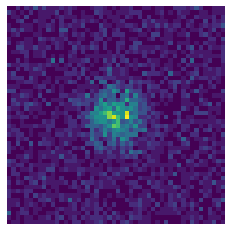

In [18]:
for i in range(200):
    sim.simulate(200)
    plt.imshow(sim.matrix)
    display.clear_output(wait=True)
    plt.axis('off')
    plt.show()

In [19]:
# number of propensity functions scaled with bins
for n in range(2, 11):
    print(f"bins = {n}^2 = {n**2}: {4*np.math.factorial(n)}")

bins = 2^2 = 4: 8
bins = 3^2 = 9: 24
bins = 4^2 = 16: 96
bins = 5^2 = 25: 480
bins = 6^2 = 36: 2880
bins = 7^2 = 49: 20160
bins = 8^2 = 64: 161280
bins = 9^2 = 81: 1451520
bins = 10^2 = 100: 14515200
